In [1]:
import glob, os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import geopy.distance
import sklearn
import warnings
warnings.filterwarnings('ignore')

### EDA,  Data Preprocessing

In [2]:
data_raw = pd.read_csv('/Users/yul/Desktop/Github Fetch/LA_metro_bike_relocation/metro-bike-share-trip-data.csv')
data_raw = data_raw.dropna(axis=0, how='any')

In [3]:
# Number of each passholder types
mask = data_raw[data_raw['Passholder Type'] == 'Staff Annual'].index
data_raw.drop(mask,inplace=True)
data_raw['Passholder Type'].value_counts()

Monthly Pass    60093
Walk-up         30532
Flex Pass        7200
Name: Passholder Type, dtype: int64

In [4]:
# Delete Round-Trip categories.
mask = data_raw[data_raw['Trip Route Category'] == 'Round Trip'].index
data_raw.drop(mask,inplace=True)
data_raw['Trip Route Category'].value_counts()

One Way    88266
Name: Trip Route Category, dtype: int64

In [5]:
# Replace passholder types to walk-up(0) and passes (1)
ndata = data_raw.copy()
temp = {'Walk-up':0,'Monthly Pass':1,'Flex Pass':1}
ndata = ndata.replace(temp)
ndata['Passholder Type'].value_counts()

1    64025
0    24241
Name: Passholder Type, dtype: int64

In [6]:
# Calculate the manhattan distance between starting stations and ending stations
ndata['Distance'] = ndata.apply(
    (lambda row: 1.414*geopy.distance.distance(
        (row['Starting Station Latitude'], row['Starting Station Longitude']),
        (row['Ending Station Latitude'], row['Ending Station Longitude'])).miles), axis=1)
ndata = ndata.drop(['Trip ID', 'Starting Station Latitude','Starting Station Longitude',
                   'Ending Station Latitude','Ending Station Longitude',
                    'Starting Lat-Long', 'Ending Lat-Long'
                   ,'Plan Duration','End Time','Trip Route Category','Bike ID'], axis=1)
ndata.iloc[:15, :]

,Duration,Start Time,Starting Station ID,Ending Station ID,Passholder Type,Distance
5,780,2016-07-07T12:51:00,3021.0,3054.0,1,0.624264
6,600,2016-07-07T12:54:00,3022.0,3014.0,1,1.080226
7,600,2016-07-07T12:59:00,3076.0,3005.0,1,0.882587
9,960,2016-07-07T13:01:00,3031.0,3078.0,1,2.200235
10,960,2016-07-07T13:02:00,3031.0,3047.0,1,1.222394
11,720,2016-07-07T13:03:00,3063.0,3005.0,1,0.508537
12,360,2016-07-07T13:03:00,3042.0,3030.0,1,0.461304
14,660,2016-07-07T13:04:00,3054.0,3030.0,1,1.365098
15,480,2016-07-07T13:04:00,3031.0,3076.0,1,0.415487
16,2100,2016-07-07T13:06:00,3006.0,3033.0,1,0.449118


In [21]:
# ndata.to_csv('ndata.csv')
ndata = pd.read_csv('ndata.csv')

In [22]:
distance_data = ndata.sort_values(by='Distance',ascending=True).reset_index()
distance_data[distance_data['Distance']>4].head(5)
# we need to exclude station ID 4108
mask4108s = ndata[ndata['Starting Station ID'] == 4108].index
ndata.drop(mask4108s,inplace=True)
mask4108e = ndata[ndata['Ending Station ID'] == 4108].index
ndata.drop(mask4108e,inplace=True)

In [23]:
ndata['Start Time'] = pd.to_datetime(ndata['Start Time'])
ndata.dtypes

Unnamed: 0                      int64
Duration                        int64
Start Time             datetime64[ns]
Starting Station ID             int64
Ending Station ID               int64
Passholder Type                 int64
Distance                      float64
Duration_min                  float64
dtype: object

### Exploratory Data Analysis

In [24]:
# The most frequent route
temp = pd.crosstab(ndata['Starting Station ID'],ndata['Ending Station ID']) # Most popular trip
temp.stack().index[np.argmax(temp.values)]

(20, 6)

In [25]:
temp.iloc[17:21,:10] # The most popular trip counts

Ending Station ID,0,1,2,3,4,5,6,7,8,9
Starting Station ID,,,,,,,,,,
17,85,41,39,13,1,4,246,16,9,29
18,24,5,7,7,0,9,54,19,8,2
19,27,26,6,16,0,2,100,13,11,1
20,134,52,18,19,1,20,694,70,15,152


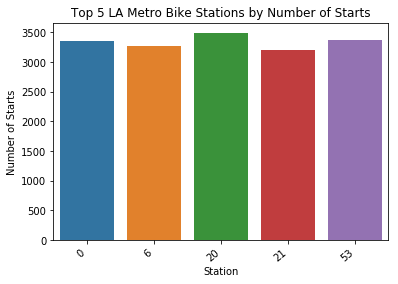

In [26]:
import seaborn as sns
top5 = pd.DataFrame()
top5['Station'] = ndata['Starting Station ID'].value_counts().head().index
top5['Number of Starts']=ndata['Starting Station ID'].value_counts().head().values
top5['Station'] = top5['Station'].astype('category')
top5['Station'] = top5.Station.cat.remove_unused_categories()

sns.barplot('Station', 'Number of Starts', data = top5)
plt.xticks(rotation=40, ha = 'right')
plt.title("Top 5 LA Metro Bike Stations by Number of Starts")
plt.show()

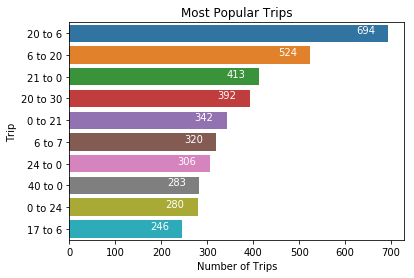

In [27]:
trips_df = pd.DataFrame()
trips_df = ndata.groupby(['Starting Station ID','Ending Station ID']).size().reset_index(name = 'Number of Trips')
trips_df = trips_df.sort_values('Number of Trips', ascending = False)
trips_df['Starting Station ID'] = trips_df['Starting Station ID'].astype('str')
trips_df['Ending Station ID'] = trips_df['Ending Station ID'].astype('str')
trips_df["Trip"] = trips_df["Starting Station ID"] + " to " + trips_df["Ending Station ID"]
trips_df = trips_df[:10]
trips_df = trips_df.drop(['Starting Station ID', "Ending Station ID"], axis = 1)
trips_df = trips_df.reset_index()

# Most popular trips
g = sns.barplot('Number of Trips','Trip', data = trips_df)
plt.title("Most Popular Trips")
for index, row in trips_df.iterrows():
    g.text(row['Number of Trips']-50,index,row['Number of Trips'], 
             color='white', ha="center",fontsize = 10)
plt.show()

In [28]:
# Assume passengers are following the average duration minutes for each pass.
# By mean
ndata['Duration_min'] = np.floor(ndata['Duration']/60)
print(ndata[['Passholder Type','Duration', 'Duration_min', 'Distance']].groupby('Passholder Type').mean())

                    Duration  Duration_min  Distance
Passholder Type                                     
0                2166.938405     36.115640  1.111945
1                 770.809696     12.846828  0.998692


In [29]:
# By median
print(ndata[['Passholder Type','Duration', 'Duration_min', 'Distance']].groupby('Passholder Type').median())

                 Duration  Duration_min  Distance
Passholder Type                                  
0                     960          16.0  1.033382
1                     480           8.0  0.866633


In [30]:
# Probability of taking a ride a day for each Pass
prob_annual = 150/1.75/365
prob_month = 17/1.75/30
prob_daily = 1
print("Annual prob. is %.2f, monthly prob. is %.2f, daily prob. is %.2f"%(prob_annual,prob_month,prob_daily))

# Minimum Utility for buying each Pass a day
util_annual = (1.75*np.ceil(150/1.75))/365
util_month = (1.75*np.ceil(17/1.75))/30
util_daily = 1.75*2 # since the avergae min. is 42.67
print("Annual utility is %.2f, monthly utility is %.2f"%(util_annual,util_month))

print(prob_annual*150)

Annual prob. is 0.23, monthly prob. is 0.32, daily prob. is 1.00
Annual utility is 0.41, monthly utility is 0.58
35.22504892367906


### Count the net demand and supply for each stations

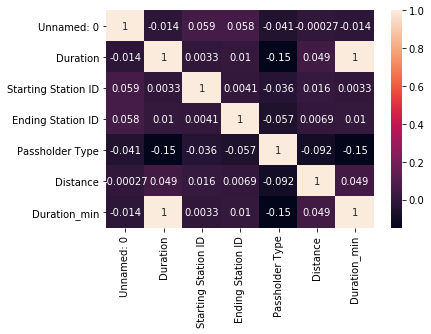

In [31]:
from sklearn import preprocessing
le1 = preprocessing.LabelEncoder()
le1.fit(ndata['Starting Station ID'])
ndata['Starting Station ID'] = le1.transform(ndata['Starting Station ID'])
keys1 = le1.classes_
values1 = le1.transform(le1.classes_)
dictionary1 = dict(zip(keys1, values1))

le2 = preprocessing.LabelEncoder()
le2.fit(ndata['Ending Station ID'])
ndata['Ending Station ID'] = le2.transform(ndata['Ending Station ID'])
keys2 = le2.classes_
values2 = le2.transform(le2.classes_)
dictionary2 = dict(zip(keys2, values2))

import seaborn as sns
sns.heatmap(ndata.corr(),annot=True)

In [36]:
# Demand for bikes at each station
d_data = ndata[['Passholder Type','Starting Station ID']].groupby('Starting Station ID').count()
d_data = d_data.rename(columns={'Starting Station ID':'ID','Passholder Type':'D'})

# Supply for bikes at each station
s_data = ndata[['Passholder Type','Ending Station ID']].groupby('Ending Station ID').count()
s_data = s_data.rename(columns={'Ending Station ID':'ID','Passholder Type':'S'})

In [37]:
# Net Supply stations
# s_data.rename(columns={'Starting Station ID':'ID'})
s_data['D'] = d_data['D']
s_data.head(3)

def calculate_nets(row):
    temp = np.maximum(row['S'] - row['D'],0)
    return temp

s_data['Net'] = s_data.apply(calculate_nets, axis=1)
s_data = s_data.drop(['D'],axis=1)
s_data.head(5)

,S,Net
Ending Station ID,,
0,4370,1011
1,2084,142
2,1334,0
3,1539,107
4,241,0


In [38]:
# Net Demand stations
# s_data.rename(columns={'Starting Station ID':'ID'})
d_data['S'] = s_data['S']
d_data.head(3)

def calculate_nets2(row):
    temp2 = np.maximum(row['D'] - row['S'],0)
    return temp2

d_data['Net'] = d_data.apply(calculate_nets2, axis=1)
d_data = d_data.drop(['S', 'D'],axis=1)
s_data = s_data.drop(['S'],axis=1)
s_data = s_data[s_data.values.sum(axis=1) != 0]
d_data = d_data[d_data.values.sum(axis=1) != 0]
d_data.head(5)

,Net
Starting Station ID,
2,488
4,39
7,21
14,731
16,230


In [39]:
s_data.head(5)

,Net
Ending Station ID,
0,1011
1,142
3,107
5,192
6,587


In [40]:
# Number of Supply stations and Demand stations
print(len(s_data), len(d_data))

36 27


In [41]:
# For pyomo formulation, change to the dictionary type 
s_data_constraint = s_data.T.to_dict('records')
d_data_constraint = d_data.T.to_dict('records')

s_data_constraint = str(s_data_constraint[0])
d_data_constraint = str(d_data_constraint[0])
d_data_constraint

import ast
s_data_constraint = ast.literal_eval(s_data_constraint)
d_data_constraint = ast.literal_eval(d_data_constraint)

### Calculate the full discount price of each route from supply stations to demand stations

In [42]:
# Set discounts
discounts = 1.75

In [43]:
cost_matrix = ndata[['Ending Station ID','Starting Station ID','Duration', 'Duration_min', 'Distance']].groupby(['Ending Station ID','Starting Station ID'],as_index=False).mean()
cost_matrix['Price'] = discounts * (np.floor(cost_matrix['Duration_min']/30)+1)
cost_matrix[:5]

,Ending Station ID,Starting Station ID,Duration,Duration_min,Distance,Price
0,0,1,525.974026,8.766234,0.351182,1.75
1,0,2,1255.636364,20.927273,0.407606,1.75
2,0,3,1032.000000,17.200000,0.353396,1.75
3,0,4,1710.000000,28.500000,1.171122,1.75
4,0,5,2896.800000,48.280000,1.023741,3.50


In [44]:
cost_matrix = cost_matrix[(cost_matrix['Ending Station ID'].isin(s_data_constraint))&
             (cost_matrix['Starting Station ID'].isin(d_data_constraint))]
# cost_matrix.to_csv('cost_matrix.csv', encoding='utf-8', index=False)

In [56]:
# Cost Dictionary for pyomo formulation.
cost_constraint = cost_matrix[(cost_matrix['Ending Station ID'].isin(s_data_constraint))&
             (cost_matrix['Starting Station ID'].isin(d_data_constraint))]
cost_constraint['key']='('+cost_constraint['Ending Station ID'].astype(str)+' , '+cost_constraint['Starting Station ID'].astype(str)+')'
cost_constraint = cost_constraint.drop(['Duration','Duration_min','Distance','Starting Station ID','Ending Station ID'],axis=1)
cost_constraint.set_index('key',inplace=True)
cost_constraint = cost_constraint.T.to_dict('records')
cost_constraint = cost_constraint[0]
cost_constraint = {ast.literal_eval(key): value 
                   for key, value in cost_constraint.items()}

In [67]:
# Distance Dictionary for pyomo formulation.
distance_matrix = ndata[['Ending Station ID','Starting Station ID','Duration', 'Duration_min', 'Distance']].groupby(['Ending Station ID','Starting Station ID'],as_index=False).mean()
distance_constraint = distance_matrix[(distance_matrix['Ending Station ID'].isin(s_data_constraint))&
             (distance_matrix['Starting Station ID'].isin(d_data_constraint))]
distance_constraint['key']='('+distance_constraint['Ending Station ID'].astype(str)+' , '+distance_constraint['Starting Station ID'].astype(str)+')'
distance_constraint = distance_constraint.drop(['Duration','Duration_min','Starting Station ID','Ending Station ID'],axis=1)
distance_constraint.set_index('key',inplace=True)
distance_constraint = distance_constraint.T.to_dict('records')
distance_constraint = distance_constraint[0]
# distance_constraint = distance_constraint[0]
distance_constraint = {ast.literal_eval(key): value 
                   for key, value in distance_constraint.items()}

In [73]:
print(len(cost_constraint.keys()),len(distance_constraint.keys()))

845 838


## Optimization

For each pair we can have a parameter $T[c,s]$ denoting the maximum amount from the current price policy over the trip. We set $R_{discount}$ as the discount rate for the 'Walk-ups' and $T[s,d]*{R_{discount}}$ as the reward for 'Passholders.' We assume the discount price and reward amount is the same for simplicity.  
What we need to determine is the amount of bikes to be relocated over each pair, which we will represent as a non-negative decision variable $x[s,d]$.

The problem objective is to minimize the total dicount amount to all demanding stations from all supplying stations. 

$$\mbox{Minimize:}\quad \mbox{Cost} = \sum_{s \in Supply Stat.}\sum_{d \in Demand Stat.} T[s,d]*{R_{discount}}*x[s,d]  +{(price\ per\ mile)}*{Distance[s,d]}*{(D[d] - x[s,d])}$$

Relocation demands from all sources can not exceed the supplying capacity of the source.

$$\sum_{d \in Demand Stat.} x[s,d] \leq \mbox{Supply}[s] \qquad \forall s \in Supply Stat.$$

Relocations to each station must satisfy their demand.

$$\sum_{s\in Supply Stat.} x[s,d] = \mbox{Demand}[d] * {P_{realized}(R_{discount})} \qquad \forall d \in Demand Stat.$$

In [89]:
# Data file
Demand = d_data_constraint
Supply = s_data_constraint
Distance = distance_constraint

import copy
T = copy.deepcopy(cost_constraint)
missing_pairs = {
  (1,60):200,
  (3,7):200,
  (3,38):200,
  (3,39):200,
  (3,60):200,
  (5,38):200,
  (5,39):200,
  (5,50):200,
  (5,57):200,
  (6,38):200,
  (8,32):200,
  (8,38):200,
  (8,39):200,
  (9,38):200,
  (9,29):200,
  (10,2):200,  
  (10,14):200,
  (10,16):200,
  (10,18):200,
  (10,20):200,
  (10,29):200,
  (10,32):200,
  (10,35):200,
  (10,38):200,
  (10,44):200,
  (10,46):200,
  (10,50):200,
  (10,52):200,
  (11,4):200,
  (11,60):200,
  (11,38):200,
  (12,4):200,
  (12,38):200,
  (12,60):200,  
  (13,38):200,
  (13,60):200,
  (15,7):200,
  (15,14):200,
  (15,16):200,
  (15,19):200, 
  (15,35):200,
  (15,38):200,
  (15,39):200,
  (21,38):200,
  (22,60):200,
  (23,32):200,
  (23,37):200,
  (23,38):200,
  (23,39):200,
  (23,50):200,
  (24,38):200,
  (24,60):200,  
  (25,38):200,
  (26,4):200,
  (26,16):200,
  (26,18):200,
  (26,38):200,
  (26,44):200,
  (27,38):200,
  (27,44):200,
  (27,60):200,
  (30,38):200,
  (31,16):200,
  (31,17):200,
  (31,18):200,
  (31,19):200,
  (31,32):200,
  (31,35):200,
  (31,37):200,
  (31,38):200,  
  (31,50):200,
  (31,52):200,
  (31,53):200,
  (34,4):200,
  (34,38):200,
  (41,7):200,  
  (41,32):200,
  (41,39):200,
  (41,40):200,
  (41,60):200,
  (42,7):200,
  (42,16):200,
  (42,19):200,
  (42,38):200,
  (42,39):200,
  (42,46):200,
  (42,57):200,
  (42,60):200,  
  (43,4):200,
  (43,38):200,
  (43,44):200,
  (43,60):200,
  (45,14):200,
  (45,16):200,  
  (45,18):200,
  (45,19):200,
  (45,20):200,
  (45,32):200,
  (45,35):200,
  (45,39):200,
  (45,50):200,
  (45,57):200,
  (48,38):200,
  (49,4):200,  
  (49,33):200,
  (49,37):200,
  (49,38):200,
  (49,44):200,
  (49,60):200,
  (54,38):200,  
  (55,38):200,
  (56,29):200,
  (56,38):200,
  (58,4):200,
  (58,33):200,
  (58,39):200,
  (58,57):200,
  (58,60):200,
  (59,4):200,
  (59,16):200,
  (59,35):200,  
  (59,36):200,
  (59,38):200,
  (59,44):200,
  (59,57):200,
  (59,60):200,
  (61,16):200,  
  (61,18):200,
  (61,19):200,  
  (61,38):200,
  (61,29):200,
  (61,52):200,
  (62,4):200,
  (62,38):200,
  (63,2):200,  
  (63,4):200,
  (63,7):200,  
  (63,16):200,
  (63,17):200,
  (63,18):200,  
  (63,19):200,
  (63,14):200,  
  (63,28):200,
  (63,32):200,
  (63,35):200,  
  (63,36):200,
  (63,38):200,  
  (63,39):200,
  (63,40):200,
  (63,44):200,  
  (63,50):200,
  (63,52):200,  
  (63,57):200,
  (63,60):200
  }
T.update(missing_pairs)

## <center> Get the total cost for each discount rates</center>

In [91]:
from pyomo.environ import *

Objective_list = []
for i in [1,0.8,0.8,0.7,0.6,0.5,0.4,0.3,0.2,0.1,1e-12]:
    # Create an instance of the model
    model = ConcreteModel()
    opt = SolverFactory('gurobi_ampl')
    model.dual = Suffix(direction=Suffix.IMPORT)

    # Define discount_rate and demand_probability
    dc_rate = i
    p_dc = 100-i
    price_per_mile = 1
    miles = 1 # to be determined

    # Step 1: Define index sets
    S_list = list(Supply.keys())
    D_list = list(Demand.keys())

    # Step 2: Define the decision 
    model.x = Var(S_list, D_list, domain = NonNegativeReals)

    # Step 3: Define Objective
    model.Cost = Objective(
        expr = sum([T[s,d]*dc_rate*model.x[s,d] + 
                    price_per_mile * miles * (Demand[d]-model.x[s,d]) 
                    for s in S_list for d in D_list]),sense = minimize)

    # Step 4: Constraints
    model.src = ConstraintList()
    for s in S_list:
        model.src.add(sum([model.x[s,d] for d in D_list]) <= Supply[s])

    model.dmd = ConstraintList()
    for d in D_list:
        model.dmd.add(sum([model.x[s,d] for s in S_list]) == Demand[d]*p_dc)

    results = opt.solve(model,tee=True)
    model.solutions.store_to(results)
    Objective_list.append(model.Cost.value())
    
Objective_list

Academic license - for non-commercial use only
Gurobi 8.1.0WARNING: Loading a SolverResults object with a warning status into
    model=unknown;
        message from solver=Gurobi 8.1.0\x3a infeasible; constraint.dunbdd
        returned.; 72 simplex iterations
    deprecated. Use the .expr property getter instead
Academic license - for non-commercial use only
Gurobi 8.1.0WARNING: Loading a SolverResults object with a warning status into
    model=unknown;
        message from solver=Gurobi 8.1.0\x3a infeasible; constraint.dunbdd
        returned.; 72 simplex iterations
    deprecated. Use the .expr property getter instead
Academic license - for non-commercial use only
Gurobi 8.1.0WARNING: Loading a SolverResults object with a warning status into
    model=unknown;
        message from solver=Gurobi 8.1.0\x3a infeasible; constraint.dunbdd
        returned.; 72 simplex iterations
    deprecated. Use the .expr property getter instead
Academic license - for non-commercial use only
Gurobi 8

[844845.75,
 579935.8400000001,
 579935.8400000001,
 447078.57749999966,
 313953.1100000001,
 180559.4375,
 46897.56000000014,
 -87032.52250000004,
 -221230.8099999999,
 -355697.30250000017,
 -490432.00000208354]

In [75]:
from pyomo.environ import *

# Create an instance of the model
model = ConcreteModel()
opt = SolverFactory('gurobi_ampl')
model.dual = Suffix(direction=Suffix.IMPORT)

# Define discount_rate and demand_probability
dc_rate = 1
p_dc = 1

# Step 1: Define index sets
S_list = list(Supply.keys())
D_list = list(Demand.keys())

# Step 2: Define the decision 
model.x = Var(S_list, D_list, domain = NonNegativeReals)

# Step 3: Define Objective
model.Cost = Objective(
    expr = sum([T[s,d]*dc_rate*model.x[s,d] for s in S_list for d in D_list]),
    sense = minimize)

# Step 4: Constraints
model.src = ConstraintList()
for s in S_list:
    model.src.add(sum([model.x[s,d] for d in D_list]) <= Supply[s])
        
model.dmd = ConstraintList()
for d in D_list:
    model.dmd.add(sum([model.x[s,d] for s in S_list]) == Demand[d]*p_dc)
    
results = opt.solve(model,tee=True)
results.write()

Academic license - for non-commercial use only
Gurobi 8.1.0# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 63
  Number of variables: 972
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Message: Gurobi 8.1.0\x3a optimal solution; objective 13410.25; 99 simplex iterations
  Termination condition: optimal
  Id: 0
  Error rc: 0
  Time: 0.08983588218688965
# ----------------------------------------------------------
#   Solution Information
# ---------------------------------------

In [104]:
# Store solution in the model.
model.solutions.store_to(results)
# print(results)

In [118]:
model.Cost.value()

    deprecated. Use the .expr property getter instead


13410.25

In [105]:
# Store optimal solution into dataframe
optsol = []
for s in S_list:
    for d in D_list:
        optsol.append((s, d, model.x[s,d]()))
cols=['S','D','Optimal Moves']        
optsol = pd.DataFrame(optsol,columns=cols)
optsol = optsol[optsol['Optimal Moves']!=0]
opts_list = optsol['S'].unique().tolist()
optd_list = optsol['D'].unique().tolist()
# optsol.to_csv('optimal_sol_scenario1.csv')
optsol['Optimal Moves'].sum()
# Total movements for every route pairs.

7663.0

In [99]:
optsol_analysis = optsol.copy()
optsol_analysis = cost_matrix[(cost_matrix['Ending Station ID'].isin(opts_list))&
             (cost_matrix['Starting Station ID'].isin(optd_list))]
optsol_analysis[optsol_analysis['Price']!=1.75].sort_values(by=['Ending Station ID'])
# optsol_analysis.to_csv('optimal_sol_price_scenario1.csv')

### Calculate the prices of every pass for classification learning 

In [30]:
ndata['Price0'] = 1.75 * (ndata['Duration_min']/30+1) # Price for Walk-up
ndata['Price1'] = 1.75 * ndata['Duration_min']/30+0.41 # Price for Passholders

### Random Forest Modeling (Training)

In [74]:
discount = 1.75
train = ndata[['Ending Station ID','Starting Station ID','Duration', 'Duration_min', 'Distance','Passholder Type']].groupby(['Ending Station ID','Starting Station ID'],as_index=False).count()
# train = ndata[['Ending Station ID','Starting Station ID','Duration_min', 'Distance','Passholder Type']]
# train['Discounts'] = discount * (np.floor(train['Duration_min']/30)+1)
train[:5]

,Ending Station ID,Starting Station ID,Duration,Duration_min,Distance,Passholder Type
0,0,1,77,77,77,77
1,0,2,55,55,55,55
2,0,3,65,65,65,65
3,0,4,4,4,4,4
4,0,5,50,50,50,50


In [73]:
train2 = ndata[['Ending Station ID','Starting Station ID','Duration', 'Duration_min', 'Distance','Passholder Type']].groupby(['Ending Station ID','Starting Station ID'],as_index=False).sum()
train2

,Ending Station ID,Starting Station ID,Duration,Duration_min,Distance,Passholder Type
0,0,1,40500,675.0,19.123774,73
1,0,2,69060,1151.0,15.854555,42
2,0,3,67080,1118.0,16.245239,49
3,0,4,6840,114.0,3.312933,1
4,0,5,144840,2414.0,36.200187,18
5,0,6,108840,1814.0,100.044629,56
6,0,7,18000,300.0,21.991144,16
7,0,8,105360,1756.0,14.868497,21
8,0,9,54960,916.0,35.343236,40
9,0,10,15180,253.0,16.786590,9


In [67]:
X = train.iloc[:, [1,2,3,4]]
y = train['Passholder Type']

# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = 0)

# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

# Fitting Random Forest Classification to the Training set
from sklearn.ensemble import AdaBoostClassifier
classifier = AdaBoostClassifier(n_estimators = 500)
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)
sc.get_params()
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      8055
           1       1.00      1.00      1.00     21073

   micro avg       1.00      1.00      1.00     29128
   macro avg       1.00      1.00      1.00     29128
weighted avg       1.00      1.00      1.00     29128



/anaconda3/envs/yulenv/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/envs/yulenv/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda3/envs/yulenv/lib/python3.6/site-packages/ipykernel_launcher.py:12: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  if sys.path[0] == '':


In [80]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test,y_pred))

[[    0  2641   479]
 [    0 23856  2702]
 [    0  6278  7182]]


In [101]:
y_pred=pd.DataFrame(y_pred)
y_pred[0].value_counts()

1    32775
2    10363
Name: 0, dtype: int64

### Adapting Random Forest Model for new price policies (1)

In [81]:
# New Minimum Utility for buying each Pass a day
base_price = 4 ; base_time = 60 # in minutes

util_annual = (base_price*np.ceil(150/base_price))/365
util_month = (base_price*np.ceil(17/base_price))/30
util_daily = base_price*2 # since the avergae min. is 42.67
print("Annual utility is %.2f, monthly utility is %.2f"%(util_annual,util_month))

Annual utility is 0.42, monthly utility is 0.67


In [82]:
ndata_scenario1 = ndata.copy()
ndata_scenario1['Price1'] = base_price * (np.floor(ndata_scenario1['Duration_min']/base_time)+1) # Price for Walk-up
ndata_scenario1['Price2'] = base_price * np.floor((ndata_scenario1['Duration_min']/base_time)) + util_annual
# Price for Flex Pass
ndata_scenario1['Price3'] = base_price * np.floor((ndata_scenario1['Duration_min']/base_time)) + util_month
# Price for Monthly Pass

In [83]:
ndata_scenario1.head()

,Duration,Start Time,Starting Station ID,Ending Station ID,Plan Duration,Trip Route Category,Passholder Type,Distance,Duration_min,Price1,Price2,Price3,Passholder Type_1,Trip Route Category_1,Starting Station ID_1,Ending Station ID_1
0,180.0,2016-07-07 04:17:00,3014.0,3014.0,30.0,Round Trip,Monthly Pass,0.0,3.0,4.0,0.416438,0.666667,1,1,7,7
1,1980.0,2016-07-07 06:00:00,3014.0,3014.0,30.0,Round Trip,Monthly Pass,0.0,33.0,4.0,0.416438,0.666667,1,1,7,7
2,300.0,2016-07-07 10:32:00,3016.0,3016.0,365.0,Round Trip,Flex Pass,0.0,5.0,4.0,0.416438,0.666667,0,1,8,8
3,10860.0,2016-07-07 10:37:00,3016.0,3016.0,365.0,Round Trip,Flex Pass,0.0,181.0,16.0,12.416438,12.666667,0,1,8,8
4,420.0,2016-07-07 12:51:00,3032.0,3032.0,0.0,Round Trip,Walk-up,0.0,7.0,4.0,0.416438,0.666667,2,1,23,23


In [102]:
X1 = ndata_scenario1.iloc[:, [7,9,10,11,13,14,15]]
y = ndata.iloc[:, 12]

# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X1_train, X1_test, y_train, y_test = train_test_split(X1, y, test_size = 0.33, random_state = 0)

sc = StandardScaler()
X1_train = sc.fit_transform(X1_train)
X1_test = sc.transform(X1_test)

scenario1 = classifier.predict(X1_test)
from sklearn.metrics import classification_report
print(classification_report(y_test,scenario1))
print(confusion_matrix(y_test,scenario1))

/anaconda3/envs/yulenv/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/envs/yulenv/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda3/envs/yulenv/lib/python3.6/site-packages/ipykernel_launcher.py:10: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  # Remove the CWD from sys.path while we load stuff.


              precision    recall  f1-score   support

           0       0.00      0.00      0.00      3120
           1       0.67      0.90      0.77     26558
           2       0.59      0.33      0.43     13460

   micro avg       0.66      0.66      0.66     43138
   macro avg       0.42      0.41      0.40     43138
weighted avg       0.60      0.66      0.61     43138

[[    0  2699   421]
 [    0 23798  2760]
 [    0  8965  4495]]


/anaconda3/envs/yulenv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [103]:
scenario1=pd.DataFrame(scenario1)
scenario1[0].value_counts()

1    35462
2     7676
Name: 0, dtype: int64

### Adapting Random Forest Model for new price policies (2)

In [104]:
# New Minimum Utility for buying each Pass a day
base_price = 0.5 ; base_time = 10 # in minutes

util_annual = (base_price*np.ceil(150/base_price))/365
util_month = (base_price*np.ceil(17/base_price))/30
util_daily = base_price*2 # since the avergae min. is 42.67
print("Annual utility is %.2f, monthly utility is %.2f"%(util_annual,util_month))

ndata_scenario2 = ndata.copy()
ndata_scenario2['Price1'] = base_price * (np.floor(ndata_scenario2['Duration_min']/base_time)+1) # Price for Walk-up
ndata_scenario2['Price2'] = base_price * np.floor(ndata_scenario2['Duration_min']/base_time) + util_annual
# Price for Flex Pass
ndata_scenario2['Price3'] = base_price * np.floor(ndata_scenario2['Duration_min']/base_time) + util_month
# Price for Monthly Pass

X2 = ndata_scenario2.iloc[:, [7,9,10,11,13,14,15]]
y = ndata.iloc[:, 12]

# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X2_train, X2_test, y_train, y_test = train_test_split(X2, y, test_size = 0.33, random_state = 0)

sc = StandardScaler()
X2_train = sc.fit_transform(X2_train)
X2_test = sc.transform(X2_test)

scenario2 = classifier.predict(X2_test)
from sklearn.metrics import classification_report
print(classification_report(y_test,scenario2))
print(confusion_matrix(y_test,scenario2))

Annual utility is 0.41, monthly utility is 0.57


/anaconda3/envs/yulenv/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/envs/yulenv/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)
/anaconda3/envs/yulenv/lib/python3.6/site-packages/ipykernel_launcher.py:25: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.


              precision    recall  f1-score   support

           0       0.00      0.00      0.00      3120
           1       0.74      0.86      0.80     26558
           2       0.65      0.58      0.61     13460

   micro avg       0.71      0.71      0.71     43138
   macro avg       0.46      0.48      0.47     43138
weighted avg       0.66      0.71      0.68     43138

[[    0  2466   654]
 [    0 22903  3655]
 [    0  5603  7857]]


/anaconda3/envs/yulenv/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [105]:
scenario2=pd.DataFrame(scenario2)
scenario2[0].value_counts()

1    30972
2    12166
Name: 0, dtype: int64